[![Open in Colab](\"https://colab.research.google.com/assets/colab-badge.svg\")](https://colab.research.google.com/github/Sound-and-Music-Computing/smc-2023/blob/main/ML%20intro/Intro2ML_2023.ipynb)

# Chapter 1 - Linear Regression

This is the colab notebook for the introduction to machine learning of the course Sound & Music Computing at art university Linz in the Fall of 2023.

In this notebook we cover the following:

- A simple linear regression of a one-dimensional variable y depending on another one-dimensional variable y (y = a*x + b). Given some data of x and y, how to find good values for the weight a and the bias b?

- How to find good values for the weight a and the bias b if no closed-form solutions are allowed?

- What if the function is more complicated and no closed-form solution can be found?

- Introduction to pytorch, the machine learning library we use:
  - how to use models?
  - how to use losses?
  - how to use optimizers?
  - how to use  Datasets and Dataloaders?
  - how to implement a training loop?

- Machine learning training has lots of moving parts, models are black boxes, and the code notoriously hard to debug. How do we find a problem? Logging, visualization, evaluation.

In [ ]:
%matplotlib inline
import numpy as np
import random
import time
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

In [ ]:
my_matrix = [[[1,2],
              [3,4]],

             [[1,2],
              [3,4]]]
my_vect = [5, 6]

## Simple Linear Regression

Let's assume we have some data points (observations) of variable x and variable y. Both are scalar-valued, that is each observation is a single number and they are measured in pairs (x_i, y_i). For convenience we are going to generate some data, but for future models, the data stems from some data collection or measurement process and often involves some kind of sanitization, encoding, or just a general process of trying to get an intuitiion for what the data looks like.

In [ ]:
n_obs = 30
# n_obs samples/data points/observations of a uniformly distributed random variable X
X = np.random.rand(n_obs) * 20 - 10

# n_obs samples/data points/observations of a random variable Y that is dependent on X (true factor 0.5), but the measurement is noisy (Gaussian noise with mean 0 and variance 1 is added)
Y = 0.5 * X   + np.random.normal(0,1.3,n_obs)

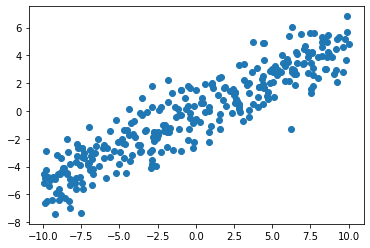

In [ ]:
plt.scatter(X,Y)

In [ ]:
# compute the parameters a and b with the formula (X.T * X) ^-1 * (X.T * Y)
X1=np.column_stack((np.ones(n_obs),X))
BA = np.matmul(np.linalg.inv(np.matmul(X1.T,X1)),np.matmul(X1.T,Y))
print(BA)

[-0.12972124  0.50795215]


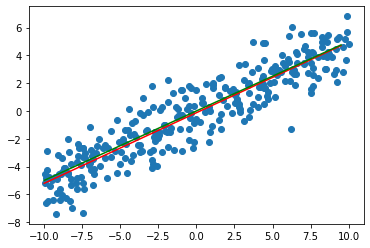

In [ ]:
# plot the estimated curve
estimated_Y = BA[1]*np.arange(-10,10,0.5) + BA[0]
plt.scatter(X,Y)
plt.plot(np.arange(-10,10,0.5), estimated_Y, c ="r")
plt.plot(np.arange(-10,10,0.5), np.arange(-10,10,0.5)*0.5, c ="g")

## (Stochastic) Gradient Descent

What if we don't know (or there isn't) a nead formula like (X.T * X) ^-1 * (X.T * Y) to find the value that make the curve approximate the data?

We use gradient descent!

What we need for this:
- the problem is formulated as an optimization problem, the "curve fitting" can be represented as a quantity which has is smaller the better the curve fits. We call this quantity the "**loss**" in machine learning, and machine learning minimizes losses.

- we need to figure out how to change weight a and bias b such that the loss becomes smaller. For any given a and b, we can compute the **derivative** of the loss with respect to a and b. Intuitively, this tells us how the loss changes if we increase a a tiny little bit from its current value.

- The collection of all (partial) derivatives of a loss with respect to a models parameters (in this case weight a and bias b) is called the **gradient**. We can decrease the loss slightly, by moving the parameters in the opposite direction of the gradient.

- If we repeat this parameter adjustment by negative gradient many times, we approach a minimal value of the loss. This is called gradient descent. The individual steps are quite small, their size is given a parameter called **learning rate**. Thhe whole process is called **training**, since the steps are taken repeatedly, people also speak of a **training loop**.

Let's have look at the previous example:
- **loss** for this curve fit; the (mean) squared error of the distance between the predicted y and the true y. If the curve fits the points perfectly (which isn't possible in this case. why is that so?), this distance becomes 0. In general, the lower the distance, the better the fit, hence it is a good loss for the regression case.

loss(estimated_y,y) = (estimated_y - y) ** 2

- The **partial derivatives** are computed from the chain rule of differentiation:

dl/da = 2 * ((a * x + b) - y) * x

dl/db = 2 * ((a * x + b) - y) * 1

- To use gradient descent, we have to use initial guesses for the parameters and then successively improve them by moving them in the opposite direction of the gradient. Let's start with a = 10, b = -10

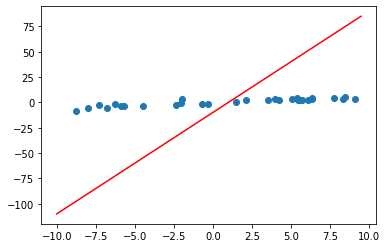

In [ ]:
# let's look at the initial guess
plt.scatter(X,Y)
plt.plot(np.arange(-10,10,0.5), np.arange(-10,10,0.5)*10-10, c ="r")

In [ ]:
# train the parameters a and b by repeatedly moving them in the negative gradient direction.
LEARNING_RATE = 0.0001
a, b = -10, 7
a_saved, b_saved = list(), list()
for k in range(100):
  # print("current a, b : ", a, b)
  a_saved.append(a)
  b_saved.append(b)
  for x, y in zip(X,Y):
    dlda = 2 * ((a * x + b) - y) * x
    dldb = 2 * ((a * x + b) - y) * 1

    a -= dlda*LEARNING_RATE
    b -= dldb*LEARNING_RATE * 10


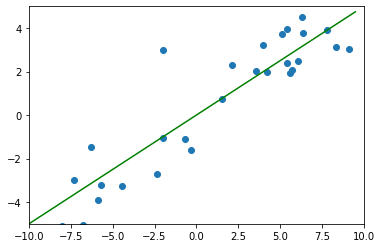

In [ ]:
# plot the development of a and b and the curve they parametrize over the course of the training
fig = plt.figure()
axis = plt.axes(xlim =(-10, 10),
                ylim =(-5, 5))

axis.scatter(X,Y)
axis.plot(np.arange(-10,10,0.5), np.arange(-10,10,0.5) * 0.5, c = "g")
line, = axis.plot([], [], c = "r")

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(np.arange(-10,10,0.5), np.arange(-10,10,0.5) * a_saved[i] + b_saved[i])
    return line,

anim = FuncAnimation(fig, animate, init_func = init, frames = 100, interval = 150, blit = True)

In [ ]:
anim

## Nonlinear, High-Dimensional, Multilayer Models

In many cases, we have high-dimensional input data (like images) and high-dimensional output data (like a segmentation of the image) and we want to use complicated models consisting of thousands of linear operations (like the linear regression) and nonlinear operations (which we'll see in a bit). Let's approach this by creating data that can no longer be approximated linearly and trying to fit a curve to it.

In [ ]:
n_obs = 300
# n_obs samples/data points/observations of a uniformly distributed random variable X
X1 = np.random.rand(n_obs) * 20 - 10

# n_obs samples/data points/observations of a random variable Y that is dependent on X
Y1 = 5 * np.cos(np.abs(X1)**(1/3)) - 2* np.sin(X1) + np.random.normal(0,1,n_obs)

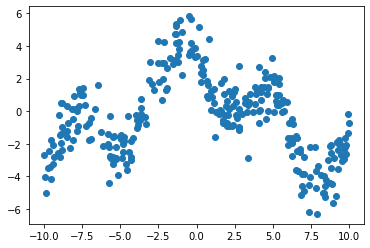

In [ ]:
plt.scatter(X1,Y1)

This data is clearly unsuitable for approximation by a straight line so we have to approach by a nonlinear function. The specific nonlinear functions we are interested in have two parts:
- a linear function with weights and biases like a and b before
- a nonlinear activation function. this is an usually unparametrized function f that tranforms the input nonlinearly:

f(a) + f(b) != f(a + b)

Common examples are:

ReLU: f(x) = max(x, 0)

tanh: f(x) = tanh(x)

sigmoid: f(x) = 1 / (1 + e ** -x)

let's make an example with 2 linear functions with sigmoid activations.

In [ ]:
def model(array):
  # this model has six parameters
  a, b, c, d, e, f, g = 1, 3, 10, -1, 5, -5.5, 0
  return c * 1 / (1 + np.exp(-(a * array + b))) + f * 1 / (1 + np.exp(-(d * array + e))) + g

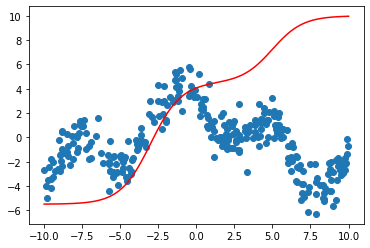

In [ ]:
xs = np.linspace(-10,10,300)
plt.scatter(X1,Y1)
plt.plot(xs,model(xs), c = "r")

The curve is nonlinear but it largely fails to approximate the points. How can we use gradient descent in this case? What do the partial derivatives of all parameters a, b, c, d, e, and f look like for this model?

## Pytorch and Autograd

Luckily for us, in this and all future models that involve nonlinear functions as described above (which we'll call layer), we don't need to derive the gradient by ourselves. Instead we rely on a library called Pytorch that computes the gradient automatically, given some training data and a specification of the model in such layers.

Let's have a look at an example consisting of three building blocks:
- a dataset
- a model
- a training loop



In [ ]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 4),
            nn.Sigmoid(),
            nn.Linear(4, 4),
            nn.Sigmoid(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        y = self.network(x)
        return y

In [ ]:
class ScalarRegressionDataset(Dataset):
    def __init__(self,data,label):
        self.data=data
        self.label=label
    def __getitem__(self, index):
        return self.data[index],self.label[index]
    def __len__(self):
        return len(self.data)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    test_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X.float())
        loss = loss_fn(pred, y.float())
        test_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0 and batch != 0:
            tloss, current = test_loss/100, batch * len(X)
            print(f"loss: {tloss:>7f}  [{current:>5d}/{size:>5d}]")
            test_loss = 0

After defining these classes and functions, we can put them together to train the network on the dataset (fit the model to the data, minimize the model's loss, ):

In [ ]:
# initialize
dataset = ScalarRegressionDataset(X1, Y1)
dataloader = DataLoader(dataset)
model = NeuralNetwork()
loss = nn.MSELoss()
optimizer = Adam(model.parameters(),lr=0.01)

# train
for epoch in range(100):
  print("Epoch ", epoch)
  train_loop(dataloader, model, loss, optimizer)

Epoch  0
loss: 5.240389  [  100/  300]
loss: 7.995483  [  200/  300]
Epoch  1
loss: 4.945970  [  100/  300]
loss: 7.656802  [  200/  300]
Epoch  2
loss: 4.499281  [  100/  300]
loss: 6.536056  [  200/  300]
Epoch  3
loss: 3.477659  [  100/  300]
loss: 4.688589  [  200/  300]
Epoch  4
loss: 2.780291  [  100/  300]
loss: 3.591043  [  200/  300]
Epoch  5
loss: 2.610342  [  100/  300]
loss: 3.188060  [  200/  300]
Epoch  6
loss: 2.566445  [  100/  300]
loss: 3.015325  [  200/  300]
Epoch  7
loss: 2.539799  [  100/  300]
loss: 2.916571  [  200/  300]
Epoch  8
loss: 2.517063  [  100/  300]
loss: 2.848772  [  200/  300]
Epoch  9
loss: 2.492779  [  100/  300]
loss: 2.794952  [  200/  300]
Epoch  10
loss: 2.452659  [  100/  300]
loss: 2.733409  [  200/  300]
Epoch  11
loss: 2.338122  [  100/  300]
loss: 2.592307  [  200/  300]
Epoch  12
loss: 2.134992  [  100/  300]
loss: 2.419339  [  200/  300]
Epoch  13
loss: 2.001330  [  100/  300]
loss: 2.315229  [  200/  300]
Epoch  14
loss: 1.924880  [  1

In [ ]:
def model_tester(model, x):
  with torch.no_grad():
    xs = torch.from_numpy(x).view(-1,1).float()
  return model(xs).detach().numpy()

In [ ]:
ys = model_tester(model, xs)

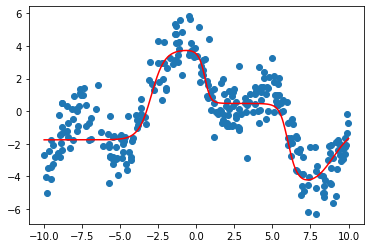

In [ ]:
plt.scatter(X1,Y1)
plt.plot(xs, ys, c = "r")

In [ ]:
for p in model.parameters():
  print(p)

Parameter containing:
tensor([[-2.1672],
        [ 1.0033],
        [ 1.5856],
        [ 3.8949]], requires_grad=True)
Parameter containing:
tensor([-6.5334, -8.3008, -9.1382, -3.0877], requires_grad=True)
Parameter containing:
tensor([[-3.1315,  4.6642,  0.2540, -4.4462],
        [-3.6389,  4.2333,  0.3797, -4.2203],
        [ 2.3500,  5.0356,  7.4609, -2.1399],
        [-4.2800, -6.7721, -8.7709,  2.3126]], requires_grad=True)
Parameter containing:
tensor([ 0.5684,  0.0693, -3.4234,  3.0292], requires_grad=True)
Parameter containing:
tensor([[ 3.4575,  2.6665, -3.1694,  2.1296]], requires_grad=True)
Parameter containing:
tensor([-1.7438], requires_grad=True)


#  Chapter 2 - Classification

Regression tasks are one of two major problem groups in supervised machine learning, the other being classification tasks. While regressions try to approximate one or mutliple numbers given an input data point, classifiers try to predict one or multiple class(es) the input data point belongs to. The main building blocks of the machine learning task remain the same however. In the Introduction to Machine Learning slides we separated these blocks like so:


- Data
- Labels
- Model
- Training Loop:
  - Compute Predictions from Input
  - Compare Predictions to Labels (Loss)
  - Update the Model (Optimizer, Gradient Descent)

## The Data and the Labels

First we will define our data and our labels. We again start with synthetic data; randomly generated values both for both. In the real world scenario this values will come from somewhere else. We will explore this scenario soon. Lets start by defining 1000 datapoints with 100 features each. The labels will be binary, meaning they will be either 0 or 1 in our example.

In [ ]:
# (Num_datapoints, Num_features)
dist0 = torch.normal(2, 3, size=(1000, 100))
dist1 = torch.normal(0, 5, size=(1000, 100))
# Same number of datapoints for labels, high is 1 more than the highest number we want to include.
labels = torch.randint(low=0, high=2, size=(1000,))
data = dist0
data[labels==0] = dist1[labels==0]

Now let's Separate our data to a Training Set and a Test Set. We will pick the first 700 samples for training and the rest for testing. Let's rename them to `x_train`, `x_test` for the data and `y_train`, `y_test` for the labels.

In [ ]:
x_train = data[:700]
x_test = data[700:]
y_train = labels[:700]
y_test = labels[700:]

## The Model

In this section we will define the model. We will use the same basic version of a Neural Network that we used for Regression called a Multi-Layer Perception or MLP. Every layer consists of a *Linear Transformation* (in torch `torch.nn.Linear(input_dims, output_dims))` followed by a *Non-Linearity* for example ReLU (in torch `torch.nn.ReLU()`.

In [ ]:
class MLP(torch.nn.Module):
    '''A Multi-Layer Perceptron Model'''
    # Initialization
    def __init__(self, num_features=100, num_hidden=128, num_labels=2, num_hlayers=2):
        super(MLP, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.non_linear_activation = torch.nn.ReLU()
        # First Layer
        self.layers.append(torch.nn.Linear(num_features, num_hidden))
        for i in range(num_hlayers - 1):
            self.layers.append(torch.nn.Linear(num_hidden, num_hidden))
        self.layers.append(torch.nn.Linear(num_hidden, num_labels))

    def forward(self, x):
        '''Update Function and predict function of the model'''
        h = x
        # Iterate of layers
        for layer in self.layers[:-1]:
            h = layer(h)
            h = self.non_linear_activation(h)
        # Last layer has no activation
        h = self.layers[-1](h)
        return h

## Initialization

In this step we will Initialize the Main components of the training framework. The Model, the Loss and the Optimizer.

- Model is an MLP
- The Loss will be Binary Cross entropy more here.
- The optimizer will be ADAM

In [ ]:
model = MLP(100, 128, 2, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_criterion = torch.nn.CrossEntropyLoss()
NUM_EPOCHS = 100

## Training Loop


In [ ]:
for epoch in range(NUM_EPOCHS):
    y_pred = model.forward(x_train)
    loss = loss_criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    # predict
    with torch.no_grad():
        pred = model.forward(x_test)
        accuracy = (pred.argmax(dim=1) == y_test).float().mean()

        print("Epoch {:03} | Loss {:.03} | Accuracy {:.03} |".format(epoch, loss.item(), accuracy.item()))

Epoch 000 | Loss 0.72 | Accuracy 0.773 |
Epoch 001 | Loss 0.58 | Accuracy 0.877 |
Epoch 002 | Loss 0.47 | Accuracy 0.94 |
Epoch 003 | Loss 0.381 | Accuracy 0.98 |
Epoch 004 | Loss 0.308 | Accuracy 0.983 |
Epoch 005 | Loss 0.246 | Accuracy 0.983 |
Epoch 006 | Loss 0.195 | Accuracy 0.987 |
Epoch 007 | Loss 0.152 | Accuracy 0.987 |
Epoch 008 | Loss 0.116 | Accuracy 0.987 |
Epoch 009 | Loss 0.0892 | Accuracy 0.99 |
Epoch 010 | Loss 0.0693 | Accuracy 0.99 |
Epoch 011 | Loss 0.0557 | Accuracy 0.99 |
Epoch 012 | Loss 0.0471 | Accuracy 0.99 |
Epoch 013 | Loss 0.0422 | Accuracy 0.99 |
Epoch 014 | Loss 0.0396 | Accuracy 0.987 |
Epoch 015 | Loss 0.0381 | Accuracy 0.987 |
Epoch 016 | Loss 0.0369 | Accuracy 0.987 |
Epoch 017 | Loss 0.0352 | Accuracy 0.987 |
Epoch 018 | Loss 0.0325 | Accuracy 0.983 |
Epoch 019 | Loss 0.0287 | Accuracy 0.987 |
Epoch 020 | Loss 0.0238 | Accuracy 0.987 |
Epoch 021 | Loss 0.0182 | Accuracy 0.987 |
Epoch 022 | Loss 0.0123 | Accuracy 0.99 |
Epoch 023 | Loss 0.00695 | Accu

# Chapter 3 - Real World Classification

[Reference Data.](https://www.kaggle.com/code/eliasdemoura/audio-classification)

- Import Audio Signals
- Spoken Digit Dataset
- Process audio samples
- Classify audio snippets to number.

In [ ]:
import torch
import tarfile
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
import torch.nn as nn
from torch.nn import functional as F
import os
import librosa
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import csv
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Audio
import scipy.io.wavfile as wav
import wave
from tqdm import tqdm
from sklearn.metrics import f1_score

#### Download and Visualize the Data

In [ ]:
!wget https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
!unzip /content/master.zip

--2022-11-10 14:15:25--  https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/refs/heads/master [following]
--2022-11-10 14:15:26--  https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [      <=>           ]  15.66M  14.3MB/s    in 1.1s    

2022-11-10 14:15:27 (14.3 MB/s) - ‘master.zip’ saved [16421388]

Archive:  /content/master.zip
4c3b0983b1b7f46ec5e49ca527e8e8844a81107e
   creating: 

In [ ]:
ndata_dir = '/content/free-spoken-digit-dataset-master/recordings/'
output_dir =  '/content/output'
SIZE = 256
BATCH_SIZE = 32
channels = 3
kernel = 4
stride = 1
pool = 2

#### Extract features from data

- Audio playback of samples from the dataset
- Investigate different representations, MFCCs, Chroma, Mel, STFT, etc.
- Extract features from the whole dataset and Save them to csv.

In [ ]:
idx = 0

data, sr = librosa.load(os.path.join(ndata_dir, os.listdir(ndata_dir)[idx]))
print(data)
print(data.shape, sr)
Audio(data=data, rate=sr)

[0.00200783 0.0025921  0.00282455 ... 0.00467513 0.00369837 0.        ]
(11163,) 22050


In [ ]:
mfcc = np.mean(librosa.feature.mfcc(y = data, sr=sr).T, axis = 0)
stft = np.abs(librosa.stft(data))
chroma = np.mean(librosa.feature.chroma_stft(S = stft, sr = sr).T, axis = 0)
mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)
contrast = np.mean(librosa.feature.spectral_contrast(S = stft, sr = sr).T, axis = 0)
tonnetz = np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(data), sr = sr).T, axis = 0)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=590
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=295
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=148
  n_fft, y.shape[-1]


In [ ]:
image = Image.fromarray(librosa.feature.mfcc(y = data, sr=sr).T, "RGB")
display(image)

In [ ]:
def extract_features(path=ndata_dir, feature="mfcc"):
    X = list()
    y = list()
    prev_viewed_speakers =list()
    print("Be patient this might take a while... \n Loading Dataset:")
    for file in tqdm(os.listdir(path)):
        if file.endswith(".wav"):
            data, sr = librosa.load(os.path.join(path, file))
            if feature == "mfcc":
                feats = np.mean(librosa.feature.mfcc(y = data, sr=sr).T, axis = 0)
            elif feature == "stft":
                feats = np.abs(librosa.stft(data))
            elif feature == "chroma":
                feats = np.mean(librosa.feature.chroma_stft(S = stft, sr = sr).T, axis = 0)
            elif feature == "mel":
                feats = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)
            elif feature == "contrast":
                feats = np.mean(librosa.feature.spectral_contrast(S = stft, sr = sr).T, axis = 0)
            elif feature == "tonnetz":
                feats = np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(data), sr = sr).T, axis = 0)
            else:
                raise ValueError("Feature {} does not exist".format(feature))

            # digit is the first element
            spoken_num, speaker, _ = file.split("_")
            # label = eval(spoken_num)
            label = speaker
            if not speaker in prev_viewed:
                prev_viewed.append(speaker)
            #print(mfccs.shape, stft.shape, chroma.shape, mel.shape, contrast.shape, tonnetz.shape)

            # row =  np.concatenate((mfccs, chroma, mel, contrast, tonnetz), axis = 0).astype('float32')
            X.append(feats)
            y.append(label)
    return np.array(X), np.array(y)

In [ ]:
X, y = extract_features()
np.unique(y)

Be patient this might take a while... 
 Loading Dataset:


100%|██████████| 3000/3000 [00:00<00:00, 158802.97it/s]


#### Create Dataloaders



In [ ]:
spokendset = TensorDataset(torch.tensor(X),torch.tensor(y))
size = len(spokendset)
val_size = int(0.1 * size)
train_size = size - val_size

train_dset, val_dset = random_split(spokendset, [train_size, val_size])

train_size, val_size
train_dl = DataLoader(train_dset, BATCH_SIZE, True)
val_dl = DataLoader(val_dset, BATCH_SIZE)

#### Create Model

The model always at least has three arguments:
1. Input Size - The input size of your features
2. Hidden Size the size of the hidden layers
3. Number of Classes - The number of Classes to predict(for spoken digits is 10 for speakers is 4).

In [ ]:
class SpokenDigitModel(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_classes=10):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.l3 = nn.Linear(int(hidden_size/2), int(hidden_size/4))
        self.l4 = nn.Linear(int(hidden_size/4), num_classes)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        return loss

    def validation_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        _, pred = torch.max(outputs, 1)
        accuracy = torch.tensor(torch.sum(pred==labels).item()/len(pred))
        return [loss.detach(), accuracy.detach()]

In [ ]:
model = SpokenDigitModel(10, 10, 10)

In [ ]:
def evaluate(model, loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in loader]
    outputs = torch.tensor(outputs).T
    loss, accuracy = torch.mean(outputs, dim=1)
    return {"loss" : loss.item(), "accuracy" : accuracy.item()}


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(model, train_loader, val_loader, epochs, lr, optimizer_function = torch.optim.Adam):
    history = []
    optimizer = optimizer_function(model.parameters(), lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        print("Epoch ", epoch)
        #Train
        model.train()
        lrs = []
        tr_loss = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            tr_loss.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        #Validate
        result = evaluate(model, val_loader)
        result["lrs"] = lrs
        result["train loss"] = torch.stack(tr_loss).mean().item()

        print("Last lr: ", lrs[-1]," Train_loss: ", result["train loss"], " Val_loss: ", result['loss'], " Accuracy: ", result['accuracy'])
        history.append(result)
    return history




### Train The Model

In [ ]:
model = SpokenDigitModel(input_size=X.shape[1], num_classes = len(unique_speakers))
history = []
evaluate(model, val_dl)


{'loss': 8.174535751342773, 'accuracy': 0.09270833432674408}

In [ ]:
history.append(fit(model, train_dl, val_dl, 64, 0.01))

Epoch  0


100%|██████████| 85/85 [00:00<00:00, 367.83it/s]


Last lr:  0.0004626922687349655  Train_loss:  2.513763666152954  Val_loss:  1.9081571102142334  Accuracy:  0.26354163885116577
Epoch  1


100%|██████████| 85/85 [00:00<00:00, 433.26it/s]


Last lr:  0.0006520798061317168  Train_loss:  1.5958635807037354  Val_loss:  1.3125735521316528  Accuracy:  0.5072916746139526
Epoch  2


100%|██████████| 85/85 [00:00<00:00, 445.31it/s]


Last lr:  0.0009631061518648332  Train_loss:  1.112029790878296  Val_loss:  0.9210834503173828  Accuracy:  0.6760417222976685
Epoch  3


100%|██████████| 85/85 [00:00<00:00, 473.14it/s]


Last lr:  0.0013874525860704066  Train_loss:  0.8233436942100525  Val_loss:  0.7031878232955933  Accuracy:  0.7166666984558105
Epoch  4


100%|██████████| 85/85 [00:00<00:00, 476.43it/s]

Last lr: 

 0.0019137695264386766  Train_loss:  0.6014435887336731  Val_loss:  0.6328033208847046  Accuracy:  0.7833333015441895
Epoch  5


100%|██████████| 85/85 [00:00<00:00, 373.14it/s]


Last lr:  0.002527980084478949  Train_loss:  0.5387852191925049  Val_loss:  0.8647238612174988  Accuracy:  0.699999988079071
Epoch  6


100%|██████████| 85/85 [00:00<00:00, 476.86it/s]


Last lr:  0.003213656566396518  Train_loss:  0.5237649083137512  Val_loss:  0.6785107851028442  Accuracy:  0.765625
Epoch  7


100%|██████████| 85/85 [00:00<00:00, 400.72it/s]


Last lr:  0.003952459848677923  Train_loss:  0.5223385691642761  Val_loss:  0.6429159045219421  Accuracy:  0.7479166984558105
Epoch  8


100%|██████████| 85/85 [00:00<00:00, 477.59it/s]


Last lr:  0.004724629876832129  Train_loss:  0.43072760105133057  Val_loss:  0.5968011021614075  Accuracy:  0.7614582777023315
Epoch  9


100%|██████████| 85/85 [00:00<00:00, 452.13it/s]


Last lr:  0.005509514168393774  Train_loss:  0.4020417034626007  Val_loss:  0.5477339625358582  Accuracy:  0.8197916746139526
Epoch  10


100%|██████████| 85/85 [00:00<00:00, 488.28it/s]


Last lr:  0.006286120184831464  Train_loss:  0.40527984499931335  Val_loss:  0.4362106919288635  Accuracy:  0.831250011920929
Epoch  11


100%|██████████| 85/85 [00:00<00:00, 436.57it/s]


Last lr:  0.007033676798605688  Train_loss:  0.4215908646583557  Val_loss:  0.5311394929885864  Accuracy:  0.78125
Epoch  12


100%|██████████| 85/85 [00:00<00:00, 383.21it/s]


Last lr:  0.007732189838361804  Train_loss:  0.4249897301197052  Val_loss:  0.4120209813117981  Accuracy:  0.8416666984558105
Epoch  13


100%|██████████| 85/85 [00:00<00:00, 427.45it/s]


Last lr:  0.008362976853629835  Train_loss:  0.43326640129089355  Val_loss:  0.552477240562439  Accuracy:  0.8114582896232605
Epoch  14


100%|██████████| 85/85 [00:00<00:00, 426.72it/s]


Last lr:  0.00890916679619862  Train_loss:  0.4507152736186981  Val_loss:  0.3620719313621521  Accuracy:  0.878125011920929
Epoch  15


100%|██████████| 85/85 [00:00<00:00, 333.02it/s]


Last lr:  0.009356151253671447  Train_loss:  0.4434199929237366  Val_loss:  0.4704853892326355  Accuracy:  0.856249988079071
Epoch  16


100%|██████████| 85/85 [00:00<00:00, 296.98it/s]


Last lr:  0.009691975166497098  Train_loss:  0.46169042587280273  Val_loss:  0.4488135278224945  Accuracy:  0.84375
Epoch  17


100%|██████████| 85/85 [00:00<00:00, 296.36it/s]


Last lr:  0.009907656578347045  Train_loss:  0.39856868982315063  Val_loss:  0.4250313639640808  Accuracy:  0.8791667222976685
Epoch  18


100%|██████████| 85/85 [00:00<00:00, 320.28it/s]


Last lr:  0.009997426867785687  Train_loss:  0.4187146723270416  Val_loss:  0.6790643930435181  Accuracy:  0.784375011920929
Epoch  19


100%|██████████| 85/85 [00:00<00:00, 321.56it/s]


Last lr:  0.009992134106552784  Train_loss:  0.40107259154319763  Val_loss:  0.47918620705604553  Accuracy:  0.8656250238418579
Epoch  20


100%|██████████| 85/85 [00:00<00:00, 349.76it/s]


Last lr:  0.009960221326213456  Train_loss:  0.40672674775123596  Val_loss:  0.5149060487747192  Accuracy:  0.8125
Epoch  21


100%|██████████| 85/85 [00:00<00:00, 353.51it/s]


Last lr:  0.009903926786310545  Train_loss:  0.3493700921535492  Val_loss:  0.4578772485256195  Accuracy:  0.8697916865348816
Epoch  22


100%|██████████| 85/85 [00:00<00:00, 298.23it/s]


Last lr:  0.009823527201405897  Train_loss:  0.3604353368282318  Val_loss:  0.3270869553089142  Accuracy:  0.8604167103767395
Epoch  23


100%|██████████| 85/85 [00:00<00:00, 297.15it/s]


Last lr:  0.009719417773875232  Train_loss:  0.31492775678634644  Val_loss:  0.5894888639450073  Accuracy:  0.8104166984558105
Epoch  24


100%|██████████| 85/85 [00:00<00:00, 293.82it/s]


Last lr:  0.009592110251299626  Train_loss:  0.29611361026763916  Val_loss:  0.518416166305542  Accuracy:  0.7927082777023315
Epoch  25


100%|██████████| 85/85 [00:00<00:00, 326.56it/s]


Last lr:  0.009442230410981642  Train_loss:  0.3331853449344635  Val_loss:  0.5239971876144409  Accuracy:  0.8541666865348816
Epoch  26


100%|██████████| 85/85 [00:00<00:00, 317.55it/s]


Last lr:  0.009270514983950873  Train_loss:  0.25084224343299866  Val_loss:  0.4418247640132904  Accuracy:  0.8520833253860474
Epoch  27


100%|██████████| 85/85 [00:00<00:00, 336.69it/s]


Last lr:  0.009077808033578922  Train_loss:  0.2945996820926666  Val_loss:  0.41199904680252075  Accuracy:  0.8739582896232605
Epoch  28


100%|██████████| 85/85 [00:00<00:00, 335.77it/s]


Last lr:  0.008865056806604618  Train_loss:  0.36758938431739807  Val_loss:  0.8741426467895508  Accuracy:  0.7822917103767395
Epoch  29


100%|██████████| 85/85 [00:00<00:00, 313.60it/s]


Last lr:  0.008633307076963696  Train_loss:  0.3775310814380646  Val_loss:  0.38998880982398987  Accuracy:  0.8760417103767395
Epoch  30


100%|██████████| 85/85 [00:00<00:00, 297.43it/s]


Last lr:  0.00838369800531021  Train_loss:  0.31933775544166565  Val_loss:  0.46001893281936646  Accuracy:  0.8697916865348816
Epoch  31


100%|██████████| 85/85 [00:00<00:00, 303.61it/s]


Last lr:  0.008117456539497631  Train_loss:  0.26766473054885864  Val_loss:  0.29929283261299133  Accuracy:  0.9135416746139526
Epoch  32


100%|██████████| 85/85 [00:00<00:00, 307.88it/s]


Last lr:  0.007835891383543871  Train_loss:  0.23395848274230957  Val_loss:  0.29919081926345825  Accuracy:  0.9135416746139526
Epoch  33


100%|██████████| 85/85 [00:00<00:00, 293.56it/s]


Last lr:  0.007540386564725742  Train_loss:  0.22331352531909943  Val_loss:  0.33887991309165955  Accuracy:  0.8999999761581421
Epoch  34


100%|██████████| 85/85 [00:00<00:00, 303.51it/s]


Last lr:  0.007232394630423575  Train_loss:  0.20429837703704834  Val_loss:  0.3236042559146881  Accuracy:  0.9114583134651184
Epoch  35


100%|██████████| 85/85 [00:00<00:00, 316.95it/s]


Last lr:  0.006913429508156802  Train_loss:  0.2145942747592926  Val_loss:  0.41545042395591736  Accuracy:  0.893750011920929
Epoch  36


100%|██████████| 85/85 [00:00<00:00, 289.84it/s]


Last lr:  0.006585059063906825  Train_loss:  0.1594933420419693  Val_loss:  0.2377392053604126  Accuracy:  0.9229167103767395
Epoch  37


100%|██████████| 85/85 [00:00<00:00, 311.88it/s]


Last lr:  0.006248897395306571  Train_loss:  0.11423348635435104  Val_loss:  0.24110570549964905  Accuracy:  0.925000011920929
Epoch  38


100%|██████████| 85/85 [00:00<00:00, 318.76it/s]


Last lr:  0.005906596897579397  Train_loss:  0.1097182184457779  Val_loss:  0.29356974363327026  Accuracy:  0.9208332896232605
Epoch  39


100%|██████████| 85/85 [00:00<00:00, 302.03it/s]


Last lr:  0.005559840141227017  Train_loss:  0.09616781026124954  Val_loss:  0.22008070349693298  Accuracy:  0.9229167103767395
Epoch  40


100%|██████████| 85/85 [00:00<00:00, 331.89it/s]


Last lr:  0.005210331601391556  Train_loss:  0.11614573746919632  Val_loss:  0.26543083786964417  Accuracy:  0.9166666865348816
Epoch  41


100%|██████████| 85/85 [00:00<00:00, 310.00it/s]


Last lr:  0.004859789279545781  Train_loss:  0.0782279521226883  Val_loss:  0.21923132240772247  Accuracy:  0.934374988079071
Epoch  42


100%|██████████| 85/85 [00:00<00:00, 304.33it/s]


Last lr:  0.004509936258695003  Train_loss:  0.07945604622364044  Val_loss:  0.28040388226509094  Accuracy:  0.921875
Epoch  43


100%|██████████| 85/85 [00:00<00:00, 288.48it/s]


Last lr:  0.004162492233600785  Train_loss:  0.07452960312366486  Val_loss:  0.2220247983932495  Accuracy:  0.9437500238418579
Epoch  44


100%|██████████| 85/85 [00:00<00:00, 317.90it/s]


Last lr:  0.0038191650576594933  Train_loss:  0.07758089900016785  Val_loss:  0.2388889342546463  Accuracy:  0.9375
Epoch  45


100%|██████████| 85/85 [00:00<00:00, 300.72it/s]


Last lr:  0.003481642347986829  Train_loss:  0.06541933119297028  Val_loss:  0.23260073363780975  Accuracy:  0.9364582896232605
Epoch  46


100%|██████████| 85/85 [00:00<00:00, 343.70it/s]


Last lr:  0.0031515831899733408  Train_loss:  0.03691266477108002  Val_loss:  0.13059809803962708  Accuracy:  0.965624988079071
Epoch  47


100%|██████████| 85/85 [00:00<00:00, 340.73it/s]


Last lr:  0.0028306099820869924  Train_loss:  0.032505862414836884  Val_loss:  0.16237221658229828  Accuracy:  0.9593750238418579
Epoch  48


100%|██████████| 85/85 [00:00<00:00, 359.31it/s]


Last lr:  0.0025203004610094945  Train_loss:  0.04725755751132965  Val_loss:  0.2224258929491043  Accuracy:  0.9354166984558105
Epoch  49


100%|██████████| 85/85 [00:00<00:00, 366.31it/s]


Last lr:  0.002222179946306651  Train_loss:  0.038931187242269516  Val_loss:  0.19305923581123352  Accuracy:  0.9572917222976685
Epoch  50


100%|██████████| 85/85 [00:00<00:00, 350.48it/s]


Last lr:  0.0019377138427538756  Train_loss:  0.028630683198571205  Val_loss:  0.14948336780071259  Accuracy:  0.96875
Epoch  51


100%|██████████| 85/85 [00:00<00:00, 344.18it/s]


Last lr:  0.0016683004371715396  Train_loss:  0.029381975531578064  Val_loss:  0.15775318443775177  Accuracy:  0.9572917222976685
Epoch  52


100%|██████████| 85/85 [00:00<00:00, 360.30it/s]


Last lr:  0.0014152640251771198  Train_loss:  0.015983911231160164  Val_loss:  0.12912486493587494  Accuracy:  0.9750000238418579
Epoch  53


100%|██████████| 85/85 [00:00<00:00, 317.07it/s]


Last lr:  0.001179848401639479  Train_loss:  0.013609271496534348  Val_loss:  0.14478199183940887  Accuracy:  0.9781249761581421
Epoch  54


100%|██████████| 85/85 [00:00<00:00, 312.01it/s]


Last lr:  0.0009632107468327899  Train_loss:  0.011378230527043343  Val_loss:  0.1254926323890686  Accuracy:  0.9781249761581421
Epoch  55


100%|██████████| 85/85 [00:00<00:00, 336.61it/s]


Last lr:  0.0007664159383425639  Train_loss:  0.009738079272210598  Val_loss:  0.13893546164035797  Accuracy:  0.9697917103767395
Epoch  56


100%|██████████| 85/85 [00:00<00:00, 325.87it/s]


Last lr:  0.0005904313166835123  Train_loss:  0.009129075333476067  Val_loss:  0.13077570497989655  Accuracy:  0.9697917103767395
Epoch  57


100%|██████████| 85/85 [00:00<00:00, 323.38it/s]


Last lr:  0.0004361219303587067  Train_loss:  0.008386069908738136  Val_loss:  0.14013509452342987  Accuracy:  0.9697917103767395
Epoch  58


100%|██████████| 85/85 [00:00<00:00, 327.53it/s]


Last lr:  0.0003042462837328597  Train_loss:  0.008149338886141777  Val_loss:  0.13692528009414673  Accuracy:  0.9666666984558105
Epoch  59


100%|██████████| 85/85 [00:00<00:00, 340.36it/s]


Last lr:  0.00019545260862094147  Train_loss:  0.008003928698599339  Val_loss:  0.13653907179832458  Accuracy:  0.9666666984558105
Epoch  60


100%|██████████| 85/85 [00:00<00:00, 341.37it/s]


Last lr:  0.00011027567791908655  Train_loss:  0.007369124796241522  Val_loss:  0.13647961616516113  Accuracy:  0.9697917103767395
Epoch  61


100%|██████████| 85/85 [00:00<00:00, 320.30it/s]


Last lr:  4.913417694027851e-05  Train_loss:  0.00840224139392376  Val_loss:  0.13691239058971405  Accuracy:  0.9666666984558105
Epoch  62


100%|██████████| 85/85 [00:00<00:00, 309.75it/s]


Last lr:  1.232864537599174e-05  Train_loss:  0.007331651635468006  Val_loss:  0.13809089362621307  Accuracy:  0.9666666984558105
Epoch  63


100%|██████████| 85/85 [00:00<00:00, 321.02it/s]

Last lr:  4e-08  Train_loss:  0.007020610850304365  Val_loss:  0.1381026804447174  Accuracy:  0.9666666984558105


### Predict

In [ ]:
@torch.no_grad()
def predict_dl(model, dl):
    torch.cuda.empty_cache()
    batch_probs = []
    batch_targ = []
    for xb, yb in dl:
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        batch_targ.append(yb.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    batch_targ = torch.cat(batch_targ)
    return [list(values).index(max(values)) for values in batch_probs], batch_targ

In [ ]:
r = evaluate(model, val_dl)
yp, yt = predict_dl(model, val_dl)
print("Loss: ", r['loss'], "\nAccuracy: ", r['accuracy'], "\nF-score: ", f1_score(yt, yp, average='micro'))

Loss:  0.1381026804447174 
Accuracy:  0.9666666984558105 
F-score:  0.97


In [ ]:
losses = []
accuracies = []
last_lr = []
for i in history[0]:
    losses.append(i['loss'])
    accuracies.append(i['accuracy'])
    last_lr.append(i['lrs'][-1])

def plot(var, title):
    plt.plot(var, '-x')
    plt.title(title)

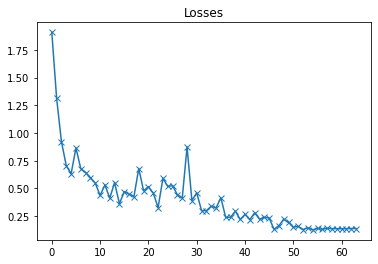

In [ ]:
plot(losses, 'Losses')

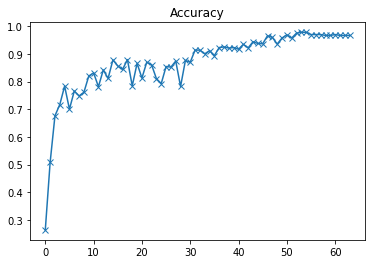

In [ ]:
plot(accuracies, 'Accuracy')

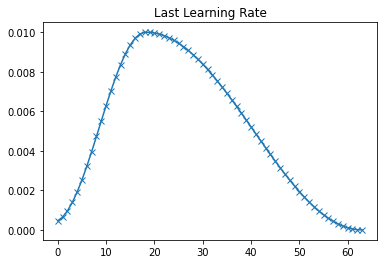

In [ ]:
plot(last_lr, 'Last Learning Rate')

# Now is your Turn!

Take our example for spoken digit classification and try to classify who is speaking instead. Remember to try different audio features and to encode any not arithmetic input such as speaker names.